# Pytorch Lab: GLM

## 1. Revisiting Linear Regression

### 1.1 Data Generation

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(452)
n = 2000 #first 1000 are train and others are test
x1 = torch.randn(n)                    
x2 = torch.normal(mean=0.0, std=2.0, size=(n,))  
x3 = torch.bernoulli(torch.full((n,), 0.5))      

y = 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


In [2]:
train[:1]

(tensor([[ 1.0000,  1.4647, -3.0439,  0.0000]]), tensor([[6.9343]]))

### 1.2 Define the negative log likelihood function

For the normal model,
$$
y_i \mid \mu_i, \sigma^2 \sim \mathcal{N}(\mu_i, \sigma^2),
$$
the negative log likelihood is
$$
-\sum_{i=1}^{n} \log\left( f(y_i \mid \mu_i, \sigma^2)\right)
= \frac{n}{2}\log(2\pi)
  + \frac{n}{2}\log(\sigma^2)
  + \frac{1}{2\sigma^2}\sum_{i=1}^{n} (y_i-\mu_i)^2,
= \sum_{i=1}^{n} [ \frac{1}{2}\log(2\pi\sigma^2)
  + \frac{(y_i-\mu_i)^2}{2\sigma^2} ] .
$$
where $\mu_i = X[i, :]^T \beta$.


In [2]:
def n_log_lik(X, Y):
    U = X @ betas
    ll = -1/2*torch.log(2*torch.pi*sigma**2) - (Y-U)**2/(2*sigma**2)
    return -torch.sum(ll)

### 1.3 Define the parameters and optimizers

- parameters: `betas`$=(\beta_0, \beta_1, \beta_2, \beta_3)$ and `sigma`


In [3]:
betas = torch.tensor(torch.randn([4,1]), requires_grad=True) # [4,1]
sigma = torch.tensor(torch.randn([1,]), requires_grad=True) # [1, ]
optimizer = torch.optim.SGD([betas, sigma], lr=0.001)

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_73396/938838282.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4,1]), requires_grad=True) # [4,1]
/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_73396/938838282.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(torch.randn([1,]), requires_grad=True) # [1, ]


### 1.4 Train the model

In [4]:
history=[]

for i in range(200):
    LOSS=0
    for xx, yy in train_loader:
      loss= n_log_lik(xx, yy)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=loss.item()
    history.append(LOSS)

tensor([[ 1.6699],
        [ 0.7751],
        [-2.5384],
        [ 0.6973]], requires_grad=True) tensor([-52.7773], requires_grad=True)


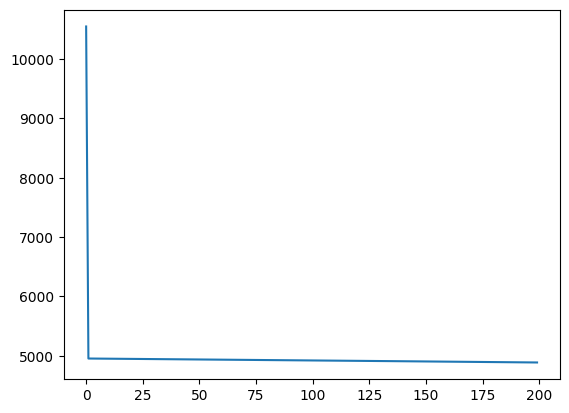

In [5]:
import matplotlib.pyplot as plt
plt.plot(history)
print(betas, sigma)
# 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))

### 1.5 Calculate Test MSE.

In [6]:
y_hat = torch.mean(train_loader.dataset[:][1])

sum_square = 0
for xx, yy in test_loader:
    yy_hat = xx @ betas
    sum_square += torch.sum((yy-yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
test_mse

tensor(14.9990, grad_fn=<DivBackward0>)

#### Is this better than no model?
#### 아무것도 안 한 모형보다 좋은지 안 좋은지.

In [7]:
y_hat = torch.mean(train_loader.dataset[:][1])

sum_square = 0
for xx, yy in test_loader:
    sum_square += torch.sum((yy - y_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
test_mse

tensor(12.0981)

### 1.6 Exercise 

Use custom layer to train the model again and calculate the test mse.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(452)
n = 2000 #first 1000 are train and others are test
x1 = torch.randn(n)                    
x2 = torch.normal(mean=0.0, std=2.0, size=(n,))  
x3 = torch.bernoulli(torch.full((n,), 0.5))      

y = 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))
ones = torch.ones([y.shape[0]])
X = torch.stack((ones, x1, x2, x3), dim=1)

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)




class GaussianReg(torch.nn.Module): # U = X@betas : torch.nn.Linear()처럼 만들기.
    def __init__(self, p):
        super().__init__()
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))

    def forward(self, X):
        mu = X @ self.betas
        return mu


def n_log_lik(mu, y, sigma):
    ll = -1/2*torch.log(2 * torch.pi * sigma**2) - (y - mu)**2 / (2 * sigma**2)
    return -torch.sum(ll)

forward = GaussianReg(p=4) # 원래는 torch.nn.Linear(4,1,bias=False)로 하는 거였는데, 이번에는 class로 사용 가능.
sigma = torch.nn.Parameter(torch.randn([1, ]), requires_grad=True)
optimizer = torch.optim.SGD(list(forward.parameters()) + [sigma], lr=0.001)

history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader:
      mu = forward(xx)
      loss= n_log_lik(mu, yy, sigma)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=loss.item()
    history.append(LOSS)

tensor([[ 1.6699],
        [ 0.7751],
        [-2.5384],
        [ 0.6973]], requires_grad=True) Parameter containing:
tensor([-46.7786], requires_grad=True)


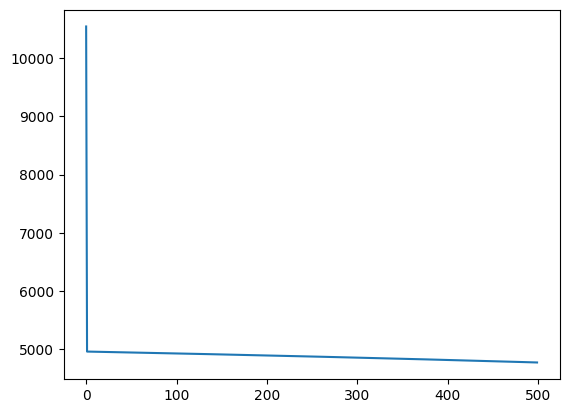

In [9]:
import matplotlib.pyplot as plt
plt.plot(history)
print(betas, sigma)

### 1.7 Exercise & HW (Video Recording)

Use the following custom layer to train the model again and calculate the test mse. Note that you have both forward function and loss function inside 

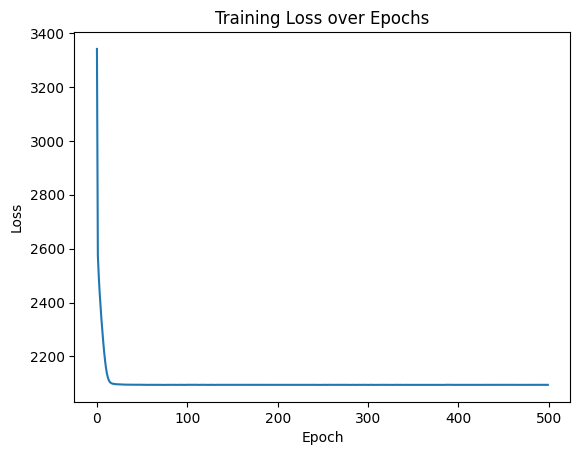

Learned parameters:
Betas: tensor([[ 1.9311,  0.8367, -1.1983,  3.0257]])
Sigma: tensor([-1.9637])

True parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0

Test MSE: 4.0744


In [10]:
import torch.nn as nn

class GaussianRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))
        self.sigma = torch.nn.Parameter(torch.randn([1,]))  # ensures sigma > 0

    def forward(self, X):
        mu = X @ self.betas
        return mu

    def loss(self, mu, y):
        ll = -1/2*torch.log(2*torch.pi*self.sigma**2) - (y - mu)**2/(2*self.sigma**2)
        nll = -torch.sum(ll)
        return nll

# Initialize model and optimizer
model = GaussianRegModel(p=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        mu = model.forward(xx)
        loss = model.loss(mu, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

print("Learned parameters:")
print("Betas:", model.betas.data.T)
print("Sigma:", model.sigma.data)
print("\nTrue parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

### 1.8 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse.

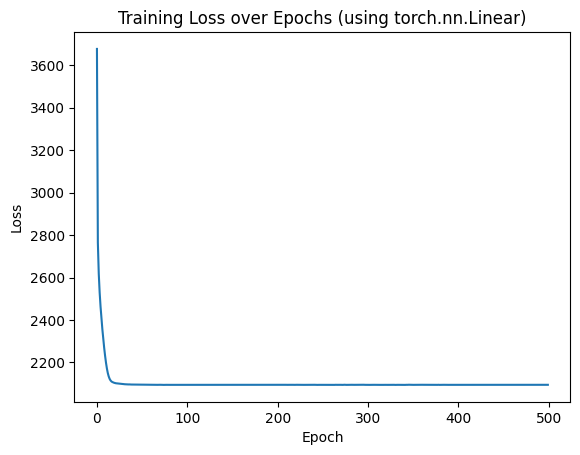

Learned parameters:
Betas (from Linear layer): tensor([[ 1.9299,  0.8318, -1.1933,  3.0250]])
Sigma: tensor([1.9709])

True parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0

Test MSE: 4.0730


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000
x1 = torch.randn(n)                    
x2 = torch.normal(mean=0.0, std=2.0, size=(n,))  
x3 = torch.bernoulli(torch.full((n,), 0.5))      

y = 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear and custom loss
class GaussianRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
        self.sigma = nn.Parameter(torch.randn([1,]))
    
    def forward(self, X):
        mu = self.linear(X)
        return mu
    
    def loss(self, mu, y):
        ll = -1/2*torch.log(2*torch.pi*self.sigma**2) - (y - mu)**2/(2*self.sigma**2)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = GaussianRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        mu = model.forward(xx)
        loss = model.loss(mu, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (using torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("Sigma:", model.sigma.data)
print("\nTrue parameters: [2.0, 0.8, -1.2, 3.0], sigma=2.0")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

## 2. Poisson regression

### 2.1 Data Generation

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(452)
n = 2000 #first 1000 are train and others are test
x1 = torch.randn(n)                    
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))      

mu = torch.exp(-2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3 )
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)


poisson_dist = torch.distributions.Poisson(mu)
y = poisson_dist.sample()


train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)



In [13]:
train_loader.dataset[:3]

(tensor([[ 1.0000,  1.4647, -1.5220,  0.0000],
         [ 1.0000, -0.1794,  0.8908,  1.0000],
         [ 1.0000, -0.4127,  2.9482,  0.0000]]),
 tensor([[1.],
         [0.],
         [0.]]))

In [14]:
train[:10]

(tensor([[ 1.0000,  1.4647, -1.5220,  0.0000],
         [ 1.0000, -0.1794,  0.8908,  1.0000],
         [ 1.0000, -0.4127,  2.9482,  0.0000],
         [ 1.0000,  0.1440, -0.2901,  1.0000],
         [ 1.0000,  0.0181,  0.0884,  1.0000],
         [ 1.0000, -0.0526,  0.8969,  0.0000],
         [ 1.0000,  0.1283, -1.4748,  1.0000],
         [ 1.0000,  0.0452, -0.2697,  1.0000],
         [ 1.0000, -1.7479, -0.5340,  1.0000],
         [ 1.0000, -0.2187, -0.2875,  1.0000]]),
 tensor([[1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [3.],
         [1.],
         [0.],
         [0.]]))

## 2.2 Write a negative-log-likelihood function as a loss function 

For the Poisson model,
$$
y_i \sim \mathrm{Pois}(\lambda_i),
$$
the negative log likelihood is
$$
-\sum_{i=1}^{n} \log f(y_i \mid \lambda_i)
= \sum_{i=1}^{n}
\left(
\lambda_i - y_i \log \lambda_i + \log(y_i!)
\right).
$$
where $\lambda_i = exp\left(X[i, :]^T \beta\right)$.

In [15]:
def n_log_lik(X, y): 
    Lam = torch.exp(X @ betas)
    ll = -Lam + y * torch.log(Lam) - torch.lgamma(y + 1)
    return -torch.sum(ll)

### 2.3 Define the parameters and optimizers

- parameters: `betas`$=(\beta_0, \beta_1, \beta_2, \beta_3)$


In [16]:
betas = torch.tensor(torch.randn([4, 1]), requires_grad=True)
optimizer = torch.optim.SGD([betas], lr=0.001)
    

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_73396/554553368.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4, 1]), requires_grad=True)


### 2.4 Train the model

In [17]:
history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader: # xx[n,4], yy[n,1]
      loss= n_log_lik(xx, yy)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+= loss.item()
    history.append(LOSS)  

tensor([[-2.0038],
        [ 0.3793],
        [-1.1828],
        [ 1.0239]], requires_grad=True)


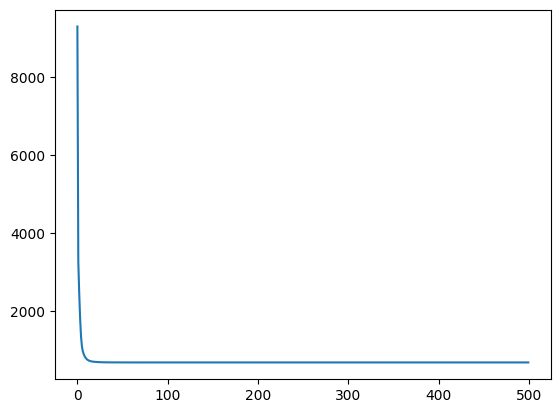

In [18]:
import matplotlib.pyplot as plt
plt.plot(history)
print(betas)
# 2.0 + 0.8*x1 - 1.2*x2 + 3.0*x3 + torch.normal(mean=0.0, std=2.0, size=(n,))

### 2.5 Calculate Test MSE.


In [19]:
sum_square = 0
for xx, yy in test_loader:
    yy_hat = torch.exp(xx @ betas) #[20, 1]
    sum_square += torch.sum(((yy - yy_hat) ** 2))

test_mse = sum_square / len(test_loader.dataset)
test_mse

tensor(0.4161, grad_fn=<DivBackward0>)

Is this better than No model?

In [20]:
y_train_mean = torch.mean(train_loader.dataset[:][1])
n=len(train_loader.dataset)
mysum = 0
for xx, yy in test_loader:
  mysum += torch.sum((yy - yy_hat) ** 2)
mysum/n

tensor(2.1584, grad_fn=<DivBackward0>)

### 2.6 Exercise 

Use custom layer to train the model again and calculate the test mse.

In [21]:
class PoissonReg(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.betas = torch.nn.Parameter()

    def forward(self, X):
        lam =     
        return lam

def n_log_lik(lam, y):                        
    ll = 
    return -torch.sum(ll)        

forward = 
optimizer = torch.optim.SGD()


history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader:
      lam = 
      loss = 
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=
    history.append()  



SyntaxError: invalid syntax (1182550934.py, line 7)

tensor([[-2.0038],
        [ 0.3793],
        [-1.1828],
        [ 1.0239]], requires_grad=True)

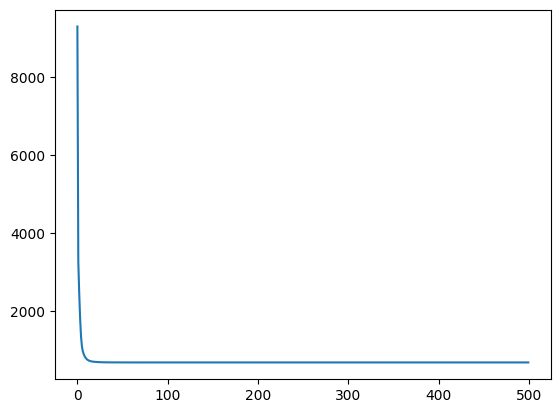

In [22]:
plt.plot(history) 
betas #mu = torch.exp(-2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3 )

### 2.7 Exercise & HW (Video Recording)

Use the following custom layer to train the model again and calculate the test mse. Note that you have both forward function and loss function inside custom layer.

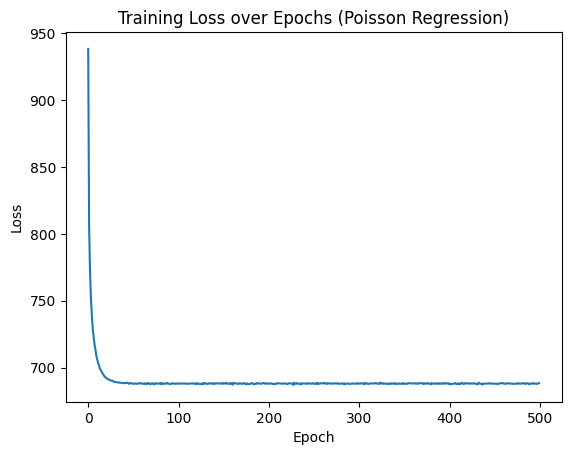

Learned parameters:
Betas: tensor([[-2.0020,  0.3794, -1.1799,  1.0235]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.4153


In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class PoissonRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))

    def forward(self, X):
        lam = torch.exp(X @ self.betas)
        return lam

    def loss(self, lam, y):        
        ll = -lam + y * torch.log(lam) - torch.lgamma(y + 1)
        return -torch.sum(ll)           


# Initialize model and optimizer
forward = PoissonRegModel(4)
optimizer = torch.optim.SGD(forward.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        lam = forward(xx)
        loss = forward.loss(lam, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Poisson Regression)')
plt.show()

print("Learned parameters:")
print("Betas:", forward.betas.data.T)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

### 2.8 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000
x1 = torch.randn(n)                    
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))      

mu = torch.exp(-2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3)
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

poisson_dist = torch.distributions.Poisson(mu)
y = poisson_dist.sample()

train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear
class PoissonRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, X):
        lam = torch.exp(self.linear(X))
        return lam
    
    def loss(self, lam, y):
        ll = -lam + y * torch.log(lam) - torch.lgamma(y + 1)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = PoissonRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        lam = model.forward(xx)
        loss = model.loss(lam, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Poisson with torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    yy_hat = model.forward(xx)
    sum_square += torch.sum((yy - yy_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

## 3. Logistic regression

### 3.1 Data Generation

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.manual_seed(452)
n = 2000  # first 1000 train, next 1000 test

# Covariates
x1 = torch.randn(n)
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))   # binary covariate

# Linear predictor (logit scale)
eta = -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

# Bernoulli probability using sigmoid
p = torch.sigmoid(eta)

# Generate Bernoulli response
bernoulli_dist = torch.distributions.Bernoulli(probs=p)
y = bernoulli_dist.sample()

# Design matrix
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

# Train/Test split
train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)



## 3.2 Write a negative-log-likelihood function as a loss function

For the logistic regression model,
$$
y_i \sim \mathrm{Bernoulli}(p_i),
$$
the negative log likelihood is
$$
-\sum_{i=1}^{n} \log f(y_i \mid p_i)
= -\sum_{i=1}^{n}
\left[
y_i \log p_i + (1 - y_i)\log(1 - p_i)
\right].
$$
where
$$
p_i = \sigma\!\left( X[i,:]^T \beta \right).
$$

Here the sigmiod function is defined by
$$
\sigma(z) = \frac{1}{1 + e^{-z}}\in(0,1), \qquad z\in\mathbb{R}
$$

In [ ]:
def n_log_lik(X, y):
    p = 
    ll = 
    return -torch.sum(ll)

### 3.3 Define the parameters and optimizers

- parameters: `betas`$=(\beta_0, \beta_1, \beta_2, \beta_3)$


In [25]:
betas = torch.tensor(torch.randn([4,1]), requires_grad=True)
optimizer = torch.optim.SGD([betas], lr=0.001)

/var/folders/1p/w6hpd8395gdb7ybzk5dvbcsw0000gn/T/ipykernel_73396/1601251795.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  betas = torch.tensor(torch.randn([4,1]), requires_grad=True)


### 2.4 Train the model

In [ ]:
history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader:
      loss= 
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=
    history.append()  

tensor([[-2.1583],
        [ 0.3563],
        [-1.2055],
        [ 1.1534]], requires_grad=True)


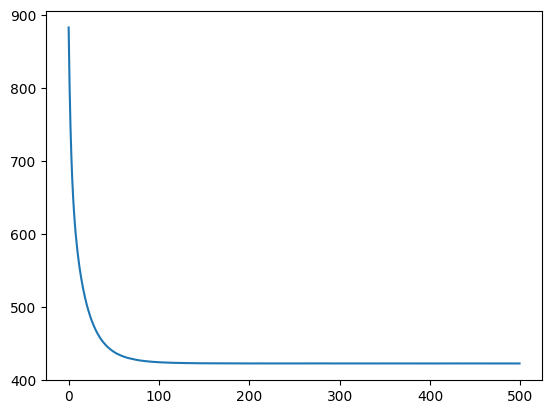

In [35]:
import matplotlib.pyplot as plt
plt.plot(history)
print(betas)
# -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

### 3.5 Calculate Test MSE.


In [ ]:
sum_square = 0
for xx, yy in test_loader:
    yy_hat = 
    sum_square = 

test_mse = 
test_mse

0.14114783316850663

Is this better than No model?

In [ ]:
y_train_mean = torch.mean(train_loader.dataset[:][1])
n=len(train_loader.dataset)
mysum = 0
for xx, yy in test_loader:
  mysum = 
mysum/n

tensor([0.1820])

### 3.6 Calculate test accuracy.

In [ ]:
sum_correct = 0

for xx, yy in test_loader:
    # predicted probability
    pp_hat = 

    # convert to 0/1 prediction
    yy_hat = (pp_hat >= 0.5).float()

    # count correct predictions
    sum_correct += 

# compute accuracy
test_accuracy = 
test_accuracy

0.799

Is this better than no model?

In [39]:
torch.mean(train_loader.dataset[:][1]) #0.2290


tensor(0.2290)

I will say test data $\hat y =0$. Then, the accuracy with no model is calculated as follows:

In [ ]:
sum_correct = 0

for xx, yy in test_loader:
    # count correct predictions
    sum_correct += 

# compute accuracy
test_accuracy = 
test_accuracy

0.761

### 3.7 Exercise 

Use custom layer to train the model again and calculate the test mse as well as test accuracy.

In [ ]:



class LogisticReg(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.betas = torch.nn.Parameter()

    def forward(self, X):
        lam =   
        return lam

def n_log_lik(p, y):
    ll = 
    return -torch.sum(ll)  

forward = 
optimizer = torch.optim.SGD()


history=[]

for i in range(500):
    LOSS=0
    for xx, yy in train_loader:
      lam = 
      loss = 
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      LOSS+=loss.item()
    history.append()  



tensor([[-2.1583],
        [ 0.3563],
        [-1.2055],
        [ 1.1534]], requires_grad=True)

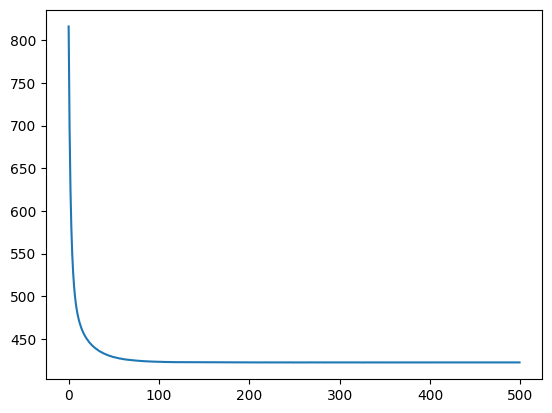

In [ ]:
plt.plot(history) 
betas # -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

### 3.8 Exercise & HW (Video Recording)

Use the following custom layer to train the model again and calculate the test mse as well as test accuracy. Note that you have both forward function and loss function inside custom layer.

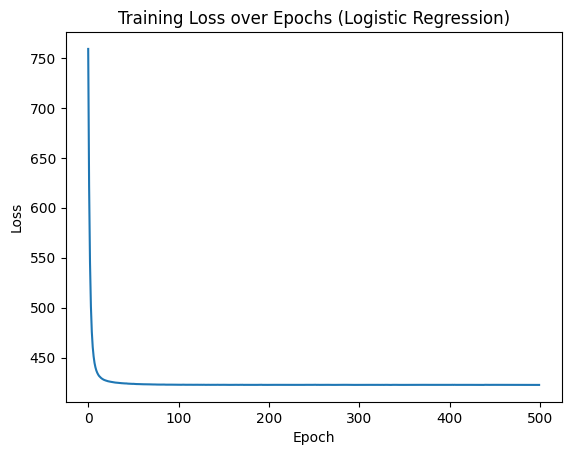

Learned parameters:
Betas: tensor([[-2.1606,  0.3592, -1.2045,  1.1523]])

True parameters: [-2.0, 0.4, -1.2, 1.0]

Test MSE: 0.1411
Test Accuracy: 0.7990
Test Accuracy: 79.90%


In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class LogisticRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p, 1]))

    def forward(self, X):
        pp = torch.sigmoid(X @ self.betas)
        return pp

    def loss(self, pp, y):        
        ll = y * torch.log(pp) + (1 - y) * torch.log(1 - pp)
        return -torch.sum(ll)           


# Initialize model and optimizer
forward = LogisticRegModel(4)
optimizer = torch.optim.SGD(forward.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        pp = forward(xx)
        loss = forward.loss(pp, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Logistic Regression)')
plt.show()

print("Learned parameters:")
print("Betas:", forward.betas.data.T)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    pp_hat = forward(xx)
    sum_square += torch.sum((yy - pp_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

# Calculate Test Accuracy
sum_correct = 0
for xx, yy in test_loader:
    # predicted probability
    pp_hat = forward(xx)
    
    # convert to 0/1 prediction
    yy_hat = (pp_hat >= 0.5).float()
    
    # count correct predictions
    sum_correct += torch.sum(yy == yy_hat).item()

# compute accuracy
test_accuracy = sum_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

### 3.9 HW

Use `torch.nn.Linear` layer to train the model again and calculate the test mse as well as test accuracy.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Regenerate data with same seed for consistency
torch.manual_seed(452)
n = 2000

# Covariates
x1 = torch.randn(n)
x2 = torch.randn(n)
x3 = torch.bernoulli(torch.full((n,), 0.5))

# Linear predictor (logit scale)
eta = -2.0 + 0.4*x1 - 1.2*x2 + 1.0*x3

# Bernoulli probability using sigmoid
p = torch.sigmoid(eta)

# Generate Bernoulli response
bernoulli_dist = torch.distributions.Bernoulli(probs=p)
y = bernoulli_dist.sample()

# Design matrix
ones = torch.ones([n])
X = torch.stack((ones, x1, x2, x3), dim=1)

# Train/Test split
train = TensorDataset(X[:1000, :], y[:1000].reshape([-1,1]))
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(X[1000:, :], y[1000:].reshape([-1,1]))
test_loader = DataLoader(test, shuffle=False, batch_size=20)


# Define model with torch.nn.Linear
class LogisticRegLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Use Linear layer without bias since we already have intercept in X
        self.linear = nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, X):
        pp = torch.sigmoid(self.linear(X))
        return pp
    
    def loss(self, pp, y):
        ll = y * torch.log(pp) + (1 - y) * torch.log(1 - pp)
        nll = -torch.sum(ll)
        return nll


# Initialize model and optimizer
model = LogisticRegLinear(input_dim=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training loop
history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        pp = model.forward(xx)
        loss = model.loss(pp, yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

# Plot training history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Logistic with torch.nn.Linear)')
plt.show()

print("Learned parameters:")
print("Betas (from Linear layer):", model.linear.weight.data)
print("\nTrue parameters: [-2.0, 0.4, -1.2, 1.0]")

# Calculate Test MSE
sum_square = 0
for xx, yy in test_loader:
    pp_hat = model.forward(xx)
    sum_square += torch.sum((yy - pp_hat)**2)

test_mse = sum_square / len(test_loader.dataset)
print(f"\nTest MSE: {test_mse.item():.4f}")

# Calculate Test Accuracy
sum_correct = 0
for xx, yy in test_loader:
    # predicted probability
    pp_hat = model.forward(xx)
    
    # convert to 0/1 prediction
    yy_hat = (pp_hat >= 0.5).float()
    
    # count correct predictions
    sum_correct += torch.sum(yy == yy_hat).item()

# compute accuracy
test_accuracy = sum_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# 4 More HW problems

## 4.1 HW problem 


We consider the Boston housing data, where the response variable is the median house value `medv` (in \$1000s). We want to model `medv` using the predictors `lstat` (lower status of the population, in %) and `age` (proportion of units built prior to 1940).

Train two models and compare the test mean squared error (MSE) of the following two models.

**Model 1 (two predictors)**  
We fit the linear regression model
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i + \beta_2\,\texttt{age}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

**Model 2 (one predictor)**  
We fit the reduced model that uses `lstat` only:
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

Using the following custom layer 
```
class GaussianRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = 
        self.sigma = 

    def forward(self, X):
        mu = 
        return mu

    def loss(self, mu, y):
        ll = 
        nll = -torch.sum(ll)
        return nll

forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)
```

Hint: 
1. You first want to make dataset(s) and dataloader(s) first.
2. Use the below code to have the data.

In [ ]:
import pandas as pd
import torch

# 1. Load CSV
df = pd.read_csv("Boston.csv")

# 2. Convert to tensor
data = torch.tensor(df.values, dtype=torch.float32)

# 3. Shuffle rows manually
n = data.shape[0]
perm = torch.randperm(n)

shuffled = data[perm]

# 4. Train/Test split (70% train, 30% test)
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# 5. Split into X and y
X_train = train[:, :-1]
y_train = train[:, -1:]

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Train X: torch.Size([354, 12])
Train y: torch.Size([354, 1])
Test X: torch.Size([152, 12])
Test y: torch.Size([152, 1])


# 4.2 HW problem
We consider the built-in dataset **`warpbreaks`**, which describes the effect of  
- wool **type** (`A` or `B`) and  
- **tension** (`low`, `medium`, or `high`)  

on the number of warp breaks per loom.  
The response variable is **`breaks`**, a count of the number of breaks.  
The predictor variables are **`type`** and **`tension`**.

Our goal is to compare the following three Poisson models (do not forget to have exponantial activation function):

- **Model 1:**  
  `breaks ~ type`

- **Model 2:**  
  `breaks ~ tension`

- **Model 3:**  
  `breaks ~ type + tension`

---

### Questions

1. **Estimate the parameters using the Bayesian method** for each of the three models (use custom layer with both forward and loss functions in it).

2. **Compute AIC** for each model based on your parameter estimates.  
   Which model is better in terms of AIC?

### Hint 1:

1. You want use the below code to extract the data.
2. Make dataset and dataloader first.
3. Since the predictors are categorical, I have converted them into dummy variables before feeding them into your model. See Hint 2 and 3 to see how this dummy variables work.

In [ ]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV manually
# -------------------------------------------------------
filename = "warpbreaks.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # breaks, wool, tension
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Prepare lists for each variable
# -------------------------------------------------------
breaks_list = []
wool_list   = []
tension_list = []

for row in rows:
    b, w, t = row

    breaks_list.append(float(b))
    wool_list.append(w)
    tension_list.append(t)

# -------------------------------------------------------
# 3. Manual dummy encoding
# -------------------------------------------------------
tension_map = {
    "L": (0.0, 0.0),
    "M": (1.0, 0.0),
    "H": (0.0, 1.0)
}

wool_map = {
    "A": 0.0,
    "B": 1.0
}

# -------------------------------------------------------
# 4. Build full matrix: [breaks, intercept, X1, X2, X3]
#    where intercept = 1.0
# -------------------------------------------------------
data_matrix = []

for i in range(len(breaks_list)):
    t1, t2 = tension_map[tension_list[i]]
    x3 = wool_map[wool_list[i]]

    row = [
        breaks_list[i],  # y
        1.0,             # intercept
        t1,              # X1 = tension_M
        t2,              # X2 = tension_H
        x3               # X3 = wool_B
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:5])

# -------------------------------------------------------
# 5. Shuffle the entire tensor
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 6. 70% train / 30% test split
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 7. Split into X and y
# -------------------------------------------------------
y_train = train[:, 0:1]      # breaks
X_train = train[:, 1:]       # intercept + X1 + X2 + X3

y_test = test[:, 0:1]
X_test = test[:, 1:]

print("Train X:", X_train.shape)  # should be (n_train, 4)
print("Train y:", y_train.shape)
print("Test X:",  X_test.shape)   # should be (n_test, 4)
print("Test y:",  y_test.shape)



Header: ['breaks', 'wool', 'tension']
First 3 rows: [['26', 'A', 'L'], ['30', 'A', 'L'], ['54', 'A', 'L']]
Full tensor shape: torch.Size([54, 5])
tensor([[26.,  1.,  0.,  0.,  0.],
        [30.,  1.,  0.,  0.,  0.],
        [54.,  1.,  0.,  0.,  0.],
        [25.,  1.,  0.,  0.,  0.],
        [70.,  1.,  0.,  0.,  0.]])
Train X: torch.Size([37, 4])
Train y: torch.Size([37, 1])
Test X: torch.Size([17, 4])
Test y: torch.Size([17, 1])


In [ ]:
X_train[:10]

tensor([[1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.]])

### Hint 2: Dummy Encoding

Categorical variables such as `"wool"` (A/B) or `"tension"` (L/M/H) cannot be used directly in most statistical or machine learning models. To include them as predictors, we must convert them into numerical form.

One commonly used approach is **dummy encoding**.  
In dummy encoding:

- A categorical variable with **K categories** is represented using **K−1 binary indicator variables**.
- One category is treated as the **baseline**, and the remaining categories are encoded with dummy variables that take the value 0 or 1.

This creates numerical predictor columns while avoiding the multicollinearity problem that occurs with full one-hot encoding.

For example, suppose we have a variable with three categories:

- Red  
- Green  
- Blue  

We can encode these using **two** dummy variables:

| Category | Encoded value (X1, X2) |
|----------|------------------------|
| Red      | (0, 0)                |
| Green    | (1, 0)                |
| Blue     | (0, 1)                |

Here:

- **Red** is the baseline category  
- **X1** represents Green  
- **X2** represents Blue  
- The intercept absorbs the baseline effect

---

```
### Toy Example in PyTorch

```python
import torch

# Suppose the categorical variable has 3 levels:
# 0 = Red, 1 = Green, 2 = Blue
cats = torch.tensor([2, 0, 1, 2], dtype=torch.long)

# We will create two dummy variables (X1, X2)
# Baseline category: Red → (0,0)
X = torch.zeros((len(cats), 2))

for i, c in enumerate(cats):
    if c == 1:          # Green
        X[i, 0] = 1
    elif c == 2:        # Blue
        X[i, 1] = 1
    # If c == 0 (Red), leave as (0,0)

print("Dummy-encoded matrix:")
print(X)
```

### Hint 3: Back to our problem




We have


| tension | dummy encoding (X1, X2) |
|---------|--------------------------|
| L       | (0, 0)                  |
| M       | (1, 0)                  |
| H       | (0, 1)                  |

| wool | dummy encoding (X3) |
|------|----------------------|
| A    | 0                    |
| B    | 1                    |


Now you have columns for `X1`, `X2`, and `X3` as well as intercept column. Hence your matrix `X` for the explanatory variable is a shape of `[n, 4]`.




## 4.3 HW problem

You are given the Default data, and want to predict one will default(`y=1`) or not(`y=0`). You have explanatory variable `student`, `balance`, and `income`. You will make two models:

1. Model 1: Use `student` and `income` to predict the `default`.
2. Model 2: Use `student`, `income` and `balance` to predict the `default`.

In terms of test accuracy, which is better? (use custom layer with `forward` method and `loss` method in it.)

In [ ]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV file manually (no pandas)
# -------------------------------------------------------
filename = "Default_data.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # skip header
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Convert categorical + numeric values
# -------------------------------------------------------
default_list = []
student_list = []
balance_list = []
income_list = []

for row in rows:
    default_str, student_str, balance_str, income_str = row

    # Yes/No → 1/0
    default = 1.0 if default_str.lower() == "yes" else 0.0
    student = 1.0 if student_str.lower() == "yes" else 0.0

    default_list.append(default)
    student_list.append(student)
    balance_list.append(float(balance_str))
    income_list.append(float(income_str))

# -------------------------------------------------------
# 3. Make a SINGLE tensor (X + y together)
#    Column order: balance, income, student, default
# -------------------------------------------------------
data_matrix = []
for i in range(len(default_list)):
    row = [
        balance_list[i],
        income_list[i],
        student_list[i],
        default_list[i]   # last column is y
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:3])

# -------------------------------------------------------
# 4. Shuffle entire dataset
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 5. Train/Test split (70/30)
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 6. Split into X and y
# -------------------------------------------------------
X_train = train[:, :-1]   # all columns except last
y_train = train[:, -1:]   # last column only

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Header: ['default', 'student', 'balance', 'income']
First 3 rows: [['No', 'No', '729.526495207286', '44361.6250742669'], ['No', 'Yes', '817.180406555498', '12106.1347003149'], ['No', 'No', '1073.54916401173', '31767.1389473999']]
Full tensor shape: torch.Size([10000, 4])
tensor([[7.2953e+02, 4.4362e+04, 0.0000e+00, 0.0000e+00],
        [8.1718e+02, 1.2106e+04, 1.0000e+00, 0.0000e+00],
        [1.0735e+03, 3.1767e+04, 0.0000e+00, 0.0000e+00]])
Train X: torch.Size([7000, 3])
Train y: torch.Size([7000, 1])
Test X: torch.Size([3000, 3])
Test y: torch.Size([3000, 1])
